# Heatmap Feature Modulation

This notebook is a planning + execution scaffold for testing **heatmap-weighted feature modulation**.

$$F'_t = F_t * (1 + \alpha H_t)$$

where:
- $F_t$: visual feature map from the detector backbone (for example, YOLO feature pyramid level P3)
- $H_t$: audio localization heatmap aligned to the video frame via homography
- $\alpha$: modulation strength (higher means stronger bias toward audio-prior regions)

Pipeline placement:
1. Build per-frame heatmap from localized audio events.
2. Run video frame through detector backbone to get $F_t$.
3. Resize heatmap to feature map size.
4. Apply modulation and pass to detection head.



In [10]:
from pathlib import Path
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

## 0) Preprocessing: Build `heatmaps.npy` from localization CSV

Use this to create training-ready numeric priors (`[T,H,W]`, float32) from:
- video metadata (fps, frame count, size)
- localization CSV (`time_min_offset` + coordinates)
- homography matrix (`top_down_H.npy`)



In [11]:
def world_to_pixel(c1, c2, H):
    pt = np.array([[[float(c1), float(c2)]]], dtype=np.float32)
    uv = cv2.perspectiveTransform(pt, H.astype(np.float32))[0, 0]
    return float(uv[0]), float(uv[1])

def add_gaussian_inplace(heat_hw, u, v, sigma_u=20.0, sigma_v=20.0, weight=1.0, cutoff=3.0):
    if (not np.isfinite(weight)) or weight <= 0:
        return
    if (not np.isfinite(sigma_u)) or sigma_u <= 0:
        sigma_u = 20.0
    if (not np.isfinite(sigma_v)) or sigma_v <= 0:
        sigma_v = 20.0
    Hh, W = heat_hw.shape
    ru = int(max(2, round(cutoff * float(sigma_u))))
    rv = int(max(2, round(cutoff * float(sigma_v))))

    u0 = max(0, int(np.floor(u)) - ru)
    u1 = min(W - 1, int(np.floor(u)) + ru)
    v0 = max(0, int(np.floor(v)) - rv)
    v1 = min(Hh - 1, int(np.floor(v)) + rv)
    if u0 >= u1 or v0 >= v1:
        return

    xs = np.arange(u0, u1 + 1, dtype=np.float32)
    ys = np.arange(v0, v1 + 1, dtype=np.float32)
    X, Y = np.meshgrid(xs, ys)

    dx = (X - float(u)) / max(1e-6, float(sigma_u))
    dy = (Y - float(v)) / max(1e-6, float(sigma_v))
    g = np.exp(-0.5 * (dx * dx + dy * dy)).astype(np.float32)
    heat_hw[v0:v1 + 1, u0:u1 + 1] += float(weight) * g

def normalize_heatmap(h, percentile=99.0, eps=1e-8):
    """Robust normalize one heatmap (H,W) to [0,1].
    Uses percentile over positive pixels so sparse maps don't collapse to zero.
    """
    h = np.asarray(h, dtype=np.float32)
    h = np.nan_to_num(h, nan=0.0, posinf=0.0, neginf=0.0)
    pos = h[h > 0]
    if pos.size > 0:
        hi = float(np.percentile(pos, percentile))
    else:
        hi = 0.0
    if hi <= eps:
        hi = float(np.max(h))
        if hi <= eps:
            return np.zeros_like(h, dtype=np.float32)
    h = np.clip(h / hi, 0.0, 1.0)
    return h.astype(np.float32)

def build_heatmaps_npy(
    video_path,
    localizations_csv,
    homography_npy,
    out_npy,
    coord_cols=("x", "y"),
    sigma_px=20.0,
    use_error_spans=True,
    normalize_each_frame=True,
):
    H = np.load(homography_npy).astype(np.float32)
    if H.shape != (3, 3):
        raise ValueError(f"Expected 3x3 homography, got {H.shape}")

    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise FileNotFoundError(video_path)
    fps = float(cap.get(cv2.CAP_PROP_FPS))
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    Hh = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    T = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()

    df = pd.read_csv(localizations_csv)
    c1_name, c2_name = coord_cols
    required = ["time_min_offset", c1_name, c2_name]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    heatmaps = np.zeros((T, Hh, W), dtype=np.float32)
    kept = 0

    for _, row in df.iterrows():
        t = float(row["time_min_offset"])
        frame_idx = int(round(t * fps))
        if frame_idx < 0 or frame_idx >= T:
            continue

        c1 = float(row[c1_name])
        c2 = float(row[c2_name])
        if not np.isfinite(c1) or not np.isfinite(c2):
            continue

        u, v = world_to_pixel(c1, c2, H)
        if not (0 <= u < W and 0 <= v < Hh):
            continue

        conf = float(row.get("confidence", 1.0))
        if not np.isfinite(conf):
            conf = 1.0
        conf = float(np.clip(conf, 0.0, 1.0))
        su = sv = float(sigma_px)
        if use_error_spans:
            e1 = row.get(f"{c1_name}_err_span", np.nan)
            e2 = row.get(f"{c2_name}_err_span", np.nan)
            if np.isfinite(e1) and float(e1) > 0:
                su = max(su, float(sigma_px) * float(e1))
            if np.isfinite(e2) and float(e2) > 0:
                sv = max(sv, float(sigma_px) * float(e2))

        add_gaussian_inplace(heatmaps[frame_idx], u, v, sigma_u=su, sigma_v=sv, weight=conf)
        kept += 1

    if normalize_each_frame:
        for t in range(T):
            heatmaps[t] = normalize_heatmap(heatmaps[t])
    else:
        vmax = float(heatmaps.max())
        if vmax > 0:
            heatmaps /= vmax

    out_path = Path(out_npy)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    np.save(out_path, heatmaps.astype(np.float32))

    print(f"[ok] saved: {out_path}")
    print(f"[ok] shape: {heatmaps.shape}, fps={fps:.3f}, added_events={kept}/{len(df)}")
    return out_path


In [12]:
# Example for your clip (edit CSV path if needed), then run.
VIDEO_PATH = "/Users/wendycao/fish/synced_pairs/3420_FishCam01_20190920T163627.613206Z_1600x1200_awb-auto_exp-night_fr-10_q-20_sh-0_b-50_c-0_i-400_sat-0/3420_FishCam01_20190920T163627.613206Z_1600x1200_awb-auto_exp-night_fr-10_q-20_sh-0_b-50_c-0_i-400_sat-0.mp4"
CSV_PATH = "/Users/wendycao/fish/XAV-arrays/localization/out_synced_pairs/3420_FishCam01_20190920T163627.613206Z_1600x1200_awb-auto_exp-night_fr-10_q-20_sh-0_b-50_c-0_i-400_sat-0/localizations_merged_filtered.csv"
H_PATH = "/Users/wendycao/fish/XAV-arrays/localization/top_down_H.npy"
OUT_NPY = "/Users/wendycao/fish/XAV-arrays/localization/out_synced_pairs/3420_FishCam01_20190920T163627.613206Z_1600x1200_awb-auto_exp-night_fr-10_q-20_sh-0_b-50_c-0_i-400_sat-0/overlays_errors/3420_heatmaps.npy"


In [13]:

out_npy = build_heatmaps_npy(
    video_path=VIDEO_PATH,
    localizations_csv=CSV_PATH,
    homography_npy=H_PATH,
    out_npy=OUT_NPY,
    coord_cols=("x", "y"),
    sigma_px=20.0,
    use_error_spans=True,
    normalize_each_frame=True,
)


[ok] saved: /Users/wendycao/fish/XAV-arrays/localization/out_synced_pairs/3420_FishCam01_20190920T163627.613206Z_1600x1200_awb-auto_exp-night_fr-10_q-20_sh-0_b-50_c-0_i-400_sat-0/overlays_errors/3420_heatmaps.npy
[ok] shape: (2995, 1200, 1600), fps=10.000, added_events=18/20


## 1) Scope and Success Criteria

### Objective
Improve fish detection by using audio heatmaps as a spatial prior while preserving baseline precision.

### Primary metrics
- `mAP50`
- `mAP50-95`
- `Recall` at fixed confidence threshold


## 2) Dataset and Alignment

Before model changes, verify:
- Homography file is correct for top-down view (`top_down_H.npy`)
- Heatmap coordinates use the same plane as camera setup (`x,y` for top-down)
- Video/audio timing offset is verified
- Debug overlays look correct on random samples
- Train/val/test split is fixed and saved

If prior alignment is off, modulation can harm performance even with good architecture.

Quick visual check to run each session:
1. Overlay projected heatmap on 10 random validation frames.
2. Confirm peaks land near plausible fish locations in side-view geometry.
3. Confirm timestamps line up with visible behavior.


In [7]:
# 3) Experiment configuration
CFG = {
    "project_name": "fish_heatmap_prior_v1",
    "homography_npy": "/Users/wendycao/fish/XAV-arrays/localization/top_down_H.npy",
    "train_split": "TODO",
    "val_split": "TODO",
    "baseline_checkpoint": "TODO",
    "feature_level": "P3",          # e.g., P3, P4
    "alpha_values": [0.25, 0.5, 1.0, 2.0],
    "prior_dropout_p": 0.3,
    "gain_clip_max": 2.5,
    "coord_cols": ["x", "y"],      # top-down plane
    "seed_list": [0, 1, 2]
}
CFG

{'project_name': 'fish_heatmap_prior_v1',
 'homography_npy': '/Users/wendycao/fish/XAV-arrays/localization/top_down_H.npy',
 'train_split': 'TODO',
 'val_split': 'TODO',
 'baseline_checkpoint': 'TODO',
 'feature_level': 'P3',
 'alpha_values': [0.25, 0.5, 1.0, 2.0],
 'prior_dropout_p': 0.3,
 'gain_clip_max': 2.5,
 'coord_cols': ['x', 'y'],
 'seed_list': [0, 1, 2]}

## 4) Quick Experiment

Run these in order (smallest set that still answers if fusion helps):

1. `baseline` (no audio prior)
2. `mod_alpha_0.25`
3. `mod_alpha_0.5`
4. `mod_alpha_1.0`
5. `mod_alpha_2.0`
6. `best_alpha + prior_dropout`
7. `best_alpha + prior_dropout + gain_clip`

Definitions:
- `mod_alpha`: same as `alpha` in $F'_t = F_t * (1 + \alpha H_t)$.
- `prior_dropout`: during training only, randomly set some heatmaps to zero to avoid over-reliance.
- `gain_clip`: cap the multiplier `(1 + alpha * H_t)` so noisy peaks do not over-amplify features.


## 5) Heatmap Representation

- load/save heatmaps as `[T,H,W]` float32 tensors
- normalize heatmaps to `[0,1]`
- overlay random frames for alignment sanity checks


In [16]:
def load_heatmap_tensor(npy_path, normalize=True):
    """Load heatmaps from .npy as float32 [T,H,W]."""
    arr = np.load(npy_path)
    if arr.ndim != 3:
        raise ValueError(f"Expected [T,H,W], got shape {arr.shape}")
    arr = arr.astype(np.float32)
    if normalize:
        arr = np.stack([normalize_heatmap(h) for h in arr], axis=0)
    return arr

def save_heatmap_tensor(arr_thw, npy_path):
    """Save heatmaps as float32 [T,H,W]."""
    arr = np.asarray(arr_thw, dtype=np.float32)
    if arr.ndim != 3:
        raise ValueError(f"Expected [T,H,W], got shape {arr.shape}")
    np.save(npy_path, arr)

def overlay_heatmap(frame_bgr, heat_hw, alpha=0.45, cmap=cv2.COLORMAP_JET):
    """Overlay one [H,W] heatmap on a BGR frame."""
    h = normalize_heatmap(heat_hw)
    heat_u8 = np.clip(255.0 * h, 0, 255).astype(np.uint8)
    heat_color = cv2.applyColorMap(heat_u8, cmap)
    if heat_color.shape[:2] != frame_bgr.shape[:2]:
        heat_color = cv2.resize(heat_color, (frame_bgr.shape[1], frame_bgr.shape[0]))
    return cv2.addWeighted(frame_bgr, 1.0 - alpha, heat_color, alpha, 0)

def preview_clip_heatmaps(
    video_path,
    heatmap_npy,
    n_samples=12,
    alpha=0.45,
    seed=0,
    prefer_localized=True,
    localized_eps=1e-6,
    selection="top",  # "top" or "random"
    draw_peak_dot=True,
    peak_dot_size=40,
):
    """Visual sanity check: show overlays, optionally prioritizing localized frames."""
    heat = load_heatmap_tensor(heatmap_npy, normalize=True)  # [T,H,W]
    T = heat.shape[0]

    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise FileNotFoundError(video_path)

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    use_T = min(T, n_frames)
    if use_T <= 0:
        cap.release()
        raise RuntimeError("No frames available")

    rng = random.Random(seed)
    frame_scores = np.nanmax(heat[:use_T], axis=(1, 2))
    frame_scores = np.nan_to_num(frame_scores, nan=0.0, posinf=0.0, neginf=0.0)

    candidate_idx = np.where(frame_scores > float(localized_eps))[0]
    if prefer_localized and len(candidate_idx) > 0:
        if selection == "top":
            order = np.argsort(frame_scores[candidate_idx])[::-1]
            picks = candidate_idx[order[: min(n_samples, len(candidate_idx))]]
            picks = sorted(int(x) for x in picks)
        else:
            picks = sorted(rng.sample(list(map(int, candidate_idx)), k=min(n_samples, len(candidate_idx))))
    else:
        if prefer_localized:
            print("[warn] No localized frames found above threshold; falling back to random sampling.")
        picks = sorted(rng.sample(range(use_T), k=min(n_samples, use_T)))

    cols = 3
    rows = int(np.ceil(len(picks) / cols))
    plt.figure(figsize=(5 * cols, 3.5 * rows))

    for i, idx in enumerate(picks, start=1):
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, frame = cap.read()
        if not ok:
            continue
        over = overlay_heatmap(frame, heat[idx], alpha=alpha)
        over_rgb = cv2.cvtColor(over, cv2.COLOR_BGR2RGB)

        ax = plt.subplot(rows, cols, i)
        ax.imshow(over_rgb)
        if draw_peak_dot and frame_scores[idx] > float(localized_eps):
            v_peak, u_peak = np.unravel_index(np.nanargmax(heat[idx]), heat[idx].shape)
            ax.scatter([u_peak], [v_peak], c="red", s=peak_dot_size)
        ax.set_title(f"frame={idx}")
        ax.axis("off")

    cap.release()
    plt.tight_layout()
    plt.show()


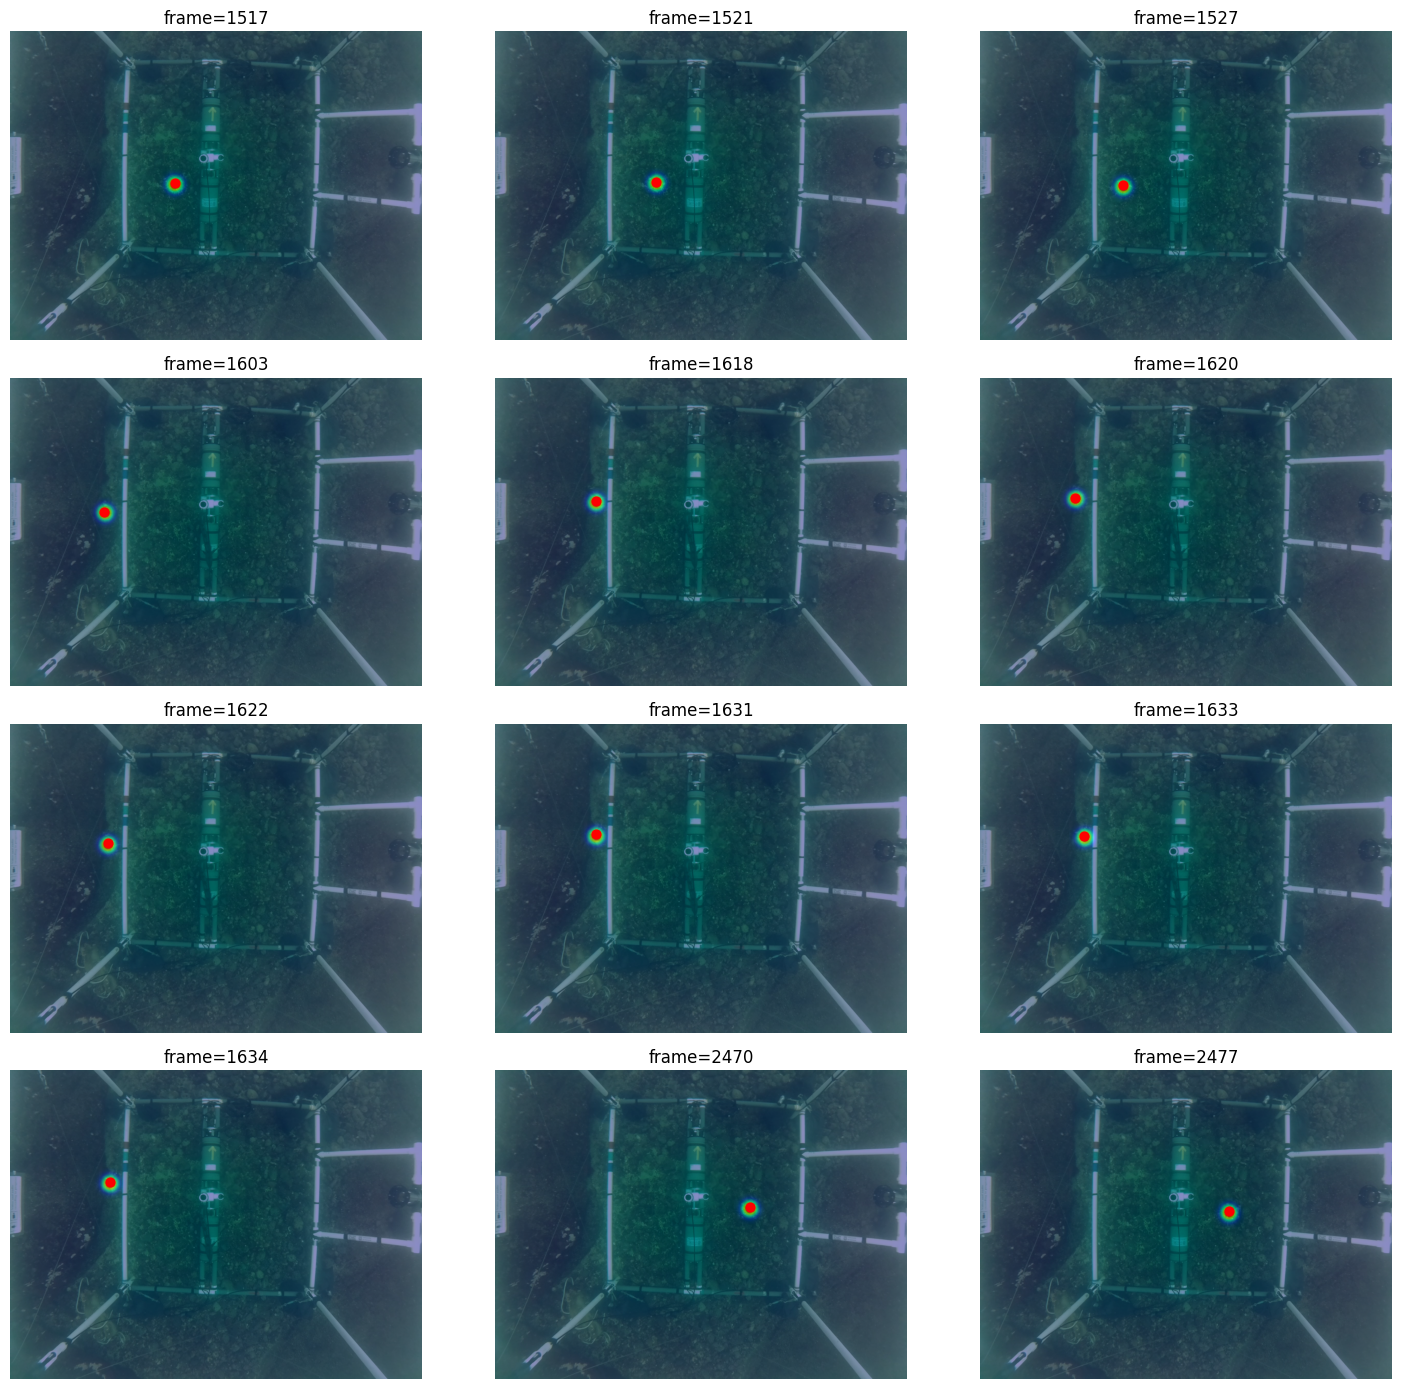

In [19]:
preview_clip_heatmaps(
    VIDEO_PATH,
    OUT_NPY,
    n_samples=12,
    alpha=0.45,
    seed=0,
    prefer_localized=True,
    localized_eps=1e-6,
    selection="top",
)

## 6) Feature Modulation

Use this module inside your detector forward pass at one feature level first (for example P3).

How YOLO uses it in practice:
1. **Dataloader output**: each sample returns `(image, labels, heatmap)` where heatmap shape is `[1,H,W]`.
2. **Batch assembly**: collate to `images [B,3,H,W]`, `heatmaps [B,1,H,W]`.
3. **Forward call**: train loop passes heatmaps into model, e.g. `model(images, heatmap_prior=heatmaps)`.
4. **Inside model**: before detect head, resize heatmap to feature map resolution with bilinear interpolation.
5. **Modulation**: apply `F' = F * (1 + alpha * H_resized)` on selected level(s), starting with P3 only.
6. **Stability options**: optionally apply prior dropout (training only) and gain clipping.
7. **Loss unchanged**: detection loss stays standard YOLO loss; only the features are modulated.

Recommended start:
- levels: `P3` only
- `alpha=0.5`
- `prior_dropout_p=0.3`
- `gain_clip_max=2.5`


In [ ]:
class HeatmapFeatureModulation(nn.Module):
    """
    Applies: F' = F * (1 + alpha * H)
    with optional prior dropout and gain clipping.
    """
    def __init__(self, alpha=0.5, prior_dropout_p=0.0, gain_clip_max=None):
        super().__init__()
        self.alpha = float(alpha)
        self.prior_dropout_p = float(prior_dropout_p)
        self.gain_clip_max = gain_clip_max

    def forward(self, feat_bchw, heat_b1hw):
        if heat_b1hw.ndim != 4 or heat_b1hw.shape[1] != 1:
            raise ValueError(f"Expected heat shape [B,1,H,W], got {tuple(heat_b1hw.shape)}")

        h = F.interpolate(heat_b1hw, size=feat_bchw.shape[-2:], mode="bilinear", align_corners=False) #dimensions may change
        h = torch.clamp(h, 0.0, 1.0)

        # Prior dropout: sometimes remove the audio prior during training.
        if self.training and self.prior_dropout_p > 0:
            keep = (torch.rand(h.shape[0], 1, 1, 1, device=h.device) > self.prior_dropout_p).float()
            h = h * keep

        gain = 1.0 + self.alpha * h
        if self.gain_clip_max is not None:
            gain = torch.clamp(gain, max=float(self.gain_clip_max))

        return feat_bchw * gain

def modulate_feature_pyramid(feats, heat_b1hw, mod):
    """
    feats: dict like {'P3': tensor, 'P4': tensor, ...}
    Applies modulation to all levels in the dict.
    """
    out = {}
    for k, v in feats.items():
        out[k] = mod(v, heat_b1hw)
    return out


In [21]:
# Sanity check: run one fake forward pass
B, C, Hf, Wf = 2, 256, 80, 80
Himg, Wimg = 640, 640

feat = torch.randn(B, C, Hf, Wf)
heat = torch.rand(B, 1, Himg, Wimg)

mod = HeatmapFeatureModulation(alpha=0.5, prior_dropout_p=0.3, gain_clip_max=2.5)
mod.train()
feat_mod = mod(feat, heat)

print("feat shape:", tuple(feat.shape))
print("heat shape:", tuple(heat.shape))
print("feat_mod shape:", tuple(feat_mod.shape))
print("mean |feat|:", float(feat.abs().mean()))
print("mean |feat_mod|:", float(feat_mod.abs().mean()))


feat shape: (2, 256, 80, 80)
heat shape: (2, 1, 640, 640)
feat_mod shape: (2, 256, 80, 80)
mean |feat|: 0.7979360818862915
mean |feat_mod|: 0.8977999687194824


## 8) Logging Template (fill each run)

For each run, log:
- Run name:
- Date:
- Seed:
- Alpha:
- Prior dropout:
- Gain clip:
- Feature level(s):
- Train epochs:
- Val metrics (`mAP50`, `mAP50-95`, `Recall`, `Precision`):
- Notes on failure cases:

Interpretation tips:
- If recall increases and precision stays similar, prior is helping.
- If precision collapses at high alpha, reduce alpha or add gain clipping.
- If gains are inconsistent across seeds, alignment/noise is likely the bottleneck.


In [ ]:
# 9) Results table scaffold
import pandas as pd

results = pd.DataFrame([
    {"run": "baseline", "alpha": 0.0, "prior_dropout": 0.0, "gain_clip": None, "mAP50": None, "mAP50_95": None, "recall": None, "precision": None},
    {"run": "mod_alpha_0.25", "alpha": 0.25, "prior_dropout": 0.0, "gain_clip": None, "mAP50": None, "mAP50_95": None, "recall": None, "precision": None},
    {"run": "mod_alpha_0.5", "alpha": 0.5, "prior_dropout": 0.0, "gain_clip": None, "mAP50": None, "mAP50_95": None, "recall": None, "precision": None},
    {"run": "mod_alpha_1.0", "alpha": 1.0, "prior_dropout": 0.0, "gain_clip": None, "mAP50": None, "mAP50_95": None, "recall": None, "precision": None},
    {"run": "mod_alpha_2.0", "alpha": 2.0, "prior_dropout": 0.0, "gain_clip": None, "mAP50": None, "mAP50_95": None, "recall": None, "precision": None}
])
results

## 10) Next Iteration

After filling results:
- Pick best model by predefined go/no-go criteria.
- Audit examples where modulation hurts detection.
- If needed, test:
  - confidence-gated prior strength
  - multi-scale prior injection
  - fallback to baseline when localization uncertainty is high
